In [55]:
from pathlib import Path

from PIL import Image
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from unet import AttUNet, UNet, UNetWithPretrainedEncoder
from dataloader import ImageDataset, TransformWrapper

data_pth = Path(
    '/Users/tsakalis/Downloads/ECImageAnalysisMouse/New Binary Masks')
blastocyst_pth = Path('/Users/tsakalis/ntua/cellforge/data/')

blastocyst_images_pth = blastocyst_pth / 'blastocyst_images'
blastocyst_msk_pth = blastocyst_pth / 'blastocyst_masks'

smooth = 1e-15

device = 'mps'


def dice_coef(y_pred, y_true):

    intersection = torch.sum(y_true.flatten() * y_pred.flatten())
    return (2. * intersection + smooth) / (
        torch.sum(y_true).flatten() + torch.sum(y_pred).flatten() + smooth)


def dice_loss(y_pred, y_true):

    return 1.0 - dice_coef(y_true, y_pred)


In [56]:
image_file_paths = []
mask_file_paths = []

for mouse in data_pth.glob('*'):
    if len(list(mouse.glob('*'))) == 2:

        msk1, msk2 = list(mouse.glob('*'))

        if 'masked' in msk2.name.lower():
            image_file_paths.append(msk1)
            mask_file_paths.append(msk2)
        else:
            mask_file_paths.append(msk1)
            image_file_paths.append(msk2)

In [57]:
# image_file_paths = sorted(list((data_pth / "images").glob('*.png')),
#                           key=lambda x: x.stem)
# mask_file_paths = sorted(list((data_pth / "masks").glob('*.png')),
#                          key=lambda x: x.stem)


In [58]:
import numpy as np
from PIL import Image
from scipy.ndimage import center_of_mass


def crop_around_center(image: Image.Image, mask: Image.Image,
                       crop_size: int) -> Image.Image:
    """
    Finds the center of mass of the non-zero pixels in the image
    and crops the image around that point.

    Args:
        image (PIL.Image.Image): Input image (grayscale or binary recommended).
        crop_size (int): Size of the square crop (e.g., 128 for 128x128 crop).

    Returns:
        PIL.Image.Image: Cropped image around the center of mass.
    """
    # Convert image to grayscale and NumPy array
    image_array = np.array(image.convert("L"))

    # Find the center of mass of non-zero pixels
    com = center_of_mass(image_array)

    # Round to integers for pixel indexing
    center_y, center_x = map(int, com)

    # Calculate crop box
    half_crop = crop_size // 2
    left = max(center_x - half_crop, 0)
    upper = max(center_y - half_crop, 0)
    right = min(center_x + half_crop, image.width)
    lower = min(center_y + half_crop, image.height)

    # Crop the image
    cropped_image = image.crop((left, upper, right, lower))

    cropped_mask = mask.crop((left, upper, right, lower))
    return cropped_image, cropped_mask


# Example usage


In [191]:
# image_file_paths = sorted(list((data_pth / "images").glob('*.jpg')),
#                           key=lambda x: x.stem)
# mask_file_paths = sorted(list((data_pth / "masks").glob('*.png')),
#                          key=lambda x: x.stem)

# print("... Loading images ...")
images = [Image.open(img_path) for img_path in tqdm(image_file_paths)]
masks = [Image.open(msk_pth) for msk_pth in tqdm(mask_file_paths)]


def remove_alpha(img):
    if img.mode == 'RGBA':  # If image has an alpha channel
        background = Image.new('RGB', img.size,
                               (255, 255, 255))  # Create white background
        background.paste(img, mask=img.split()[3])  # Use alpha channel as mask
        return background
    return img  # Return unchanged if no alpha channel


# Process images and masks
images = [remove_alpha(img) for img in tqdm(images)]
masks = [remove_alpha(msk) for msk in tqdm(masks)]

cropped_images = []
cropped_masks = []
for image, mask in zip(images, masks):

    cropped, cropped_mask = crop_around_center(image, mask, crop_size=200 * 3)

    cropped_images.append(cropped)
    cropped_masks.append(cropped_mask)

train_dataset = ImageDataset(images=cropped_images[:130],
                             masks=cropped_masks[:130],
                             transform=True)
val_dataset = ImageDataset(images=cropped_images[130:800],
                           masks=cropped_masks[130:800])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=16)


100%|██████████| 169/169 [00:02<00:00, 69.29it/s]


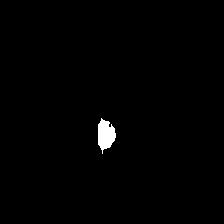

In [200]:
temp_msk = cropped_masks[160].resize((224, 224), Image.Resampling.LANCZOS)
temp_img = cropped_images[160].resize((224, 224), Image.Resampling.LANCZOS)
temp_msk = temp_msk.convert('L')
binary_threshold = 100  # Adjust this threshold as needed
mask = temp_msk.point(lambda p: 255 if p > binary_threshold else 0)
mask


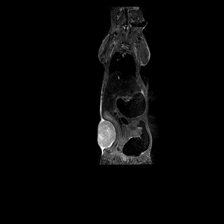

In [208]:
temp_img

In [202]:
import random
from torchvision import transforms as T
import torchvision.transforms.functional as F

In [203]:
angle = random.uniform(-90, 90)
image = F.rotate(image, angle)
mask = T.ToTensor()(F.rotate(mask, angle))

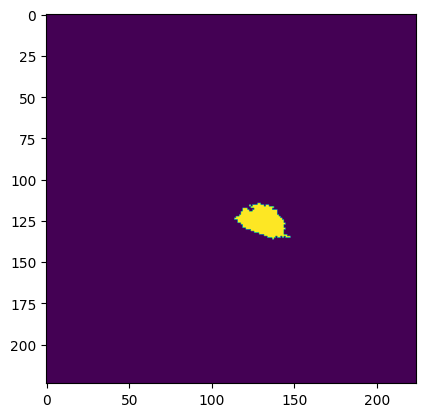

In [204]:
plt.imshow(mask.numpy()[0])

In [65]:
for im, gt in train_dataloader:
    break

In [66]:
mask.show()

In [67]:
plt.imshow(mask[0])

TypeError: 'Image' object is not subscriptable

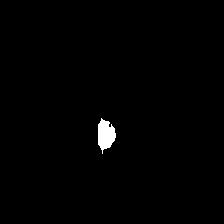

In [68]:
mask

In [69]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name=
    "resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=
    "imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=
    3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
)
model.to(device)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 30

In [70]:
import torch


def validate(model, val_dataloader):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for img_batch, gt_msk_batch in val_dataloader:

            img_batch = img_batch.to(device)
            gt_msk_batch = gt_msk_batch.to(device)

            pred_mask = model(img_batch)

            loss = dice_loss(torch.sigmoid(pred_mask), gt_msk_batch)

            val_loss += loss.item()

    mean_val_loss = val_loss / len(val_dataloader)
    return mean_val_loss


In [71]:
for epoch in range(n_epochs):
    progress_bar = tqdm(train_dataloader, total=len(train_dataloader))

    train_loss = 0
    for img_batch, gt_msk_batch in progress_bar:

        optimizer.zero_grad()
        pred_mask = model(img_batch.to(device))

        loss = dice_loss(torch.sigmoid(pred_mask), gt_msk_batch.to(device))
        loss.backward()
        optimizer.step()

        progress_bar.set_description(str(loss.item()))

        train_loss += loss.item()

    val_loss = validate(model, val_dataloader)

    print(
        f'Epoch {epoch+1} | TrainLoss: {train_loss/len(train_dataloader)} ValLoss: {val_loss}'
    )


  0%|          | 0/17 [00:00<?, ?it/s]

0.9874884486198425: 100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


Epoch 1 | TrainLoss: 0.974695714081035 ValLoss: 0.9731911222139994


0.4664266109466553: 100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


Epoch 2 | TrainLoss: 0.7638345010140363 ValLoss: 0.5564214984575907


0.09825259447097778: 100%|██████████| 17/17 [00:06<00:00,  2.56it/s]


Epoch 3 | TrainLoss: 0.3499516388949226 ValLoss: 0.28052093585332233


0.5632364153862: 100%|██████████| 17/17 [00:06<00:00,  2.52it/s]    


Epoch 4 | TrainLoss: 0.30086637595120597 ValLoss: 0.22437463204065958


0.46132922172546387: 100%|██████████| 17/17 [00:06<00:00,  2.57it/s]


Epoch 5 | TrainLoss: 0.26314761708764467 ValLoss: 0.4682759841283162


0.4120025634765625: 100%|██████████| 17/17 [00:06<00:00,  2.53it/s] 


Epoch 6 | TrainLoss: 0.2954997385249418 ValLoss: 0.20978808403015137


0.24871772527694702: 100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Epoch 7 | TrainLoss: 0.23813960482092464 ValLoss: 0.19426661729812622


0.576388955116272: 100%|██████████| 17/17 [00:06<00:00,  2.49it/s]  


Epoch 8 | TrainLoss: 0.21802296357996323 ValLoss: 0.14788738886515299


0.10956954956054688: 100%|██████████| 17/17 [00:06<00:00,  2.46it/s]


Epoch 9 | TrainLoss: 0.1825911893564112 ValLoss: 0.17265758911768594


0.17095744609832764: 100%|██████████| 17/17 [00:06<00:00,  2.52it/s]


Epoch 10 | TrainLoss: 0.16490259591270895 ValLoss: 0.1421085993448893


0.08427667617797852: 100%|██████████| 17/17 [00:07<00:00,  2.40it/s]


Epoch 11 | TrainLoss: 0.15150757046306834 ValLoss: 0.13691945870717367


0.21790730953216553: 100%|██████████| 17/17 [00:06<00:00,  2.45it/s]


Epoch 12 | TrainLoss: 0.16112184524536133 ValLoss: 0.13014777501424155


0.0921291708946228: 100%|██████████| 17/17 [00:06<00:00,  2.50it/s] 


Epoch 13 | TrainLoss: 0.1433297220398398 ValLoss: 0.139408012231191


0.09220755100250244: 100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


Epoch 14 | TrainLoss: 0.13226103081422694 ValLoss: 0.11966393391291301


0.5631145238876343: 100%|██████████| 17/17 [00:06<00:00,  2.50it/s] 


Epoch 15 | TrainLoss: 0.16089405732996323 ValLoss: 0.11261363824208577


0.42862367630004883: 100%|██████████| 17/17 [00:06<00:00,  2.45it/s]


Epoch 16 | TrainLoss: 0.1789278598392711 ValLoss: 0.13154170910517374


0.09420502185821533: 100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


Epoch 17 | TrainLoss: 0.13946957798565135 ValLoss: 0.12789116303126016


0.18513375520706177: 100%|██████████| 17/17 [00:06<00:00,  2.45it/s]


Epoch 18 | TrainLoss: 0.13087246698491714 ValLoss: 0.11551392078399658


0.069427490234375: 100%|██████████| 17/17 [00:07<00:00,  2.42it/s]  


Epoch 19 | TrainLoss: 0.11546808130600873 ValLoss: 0.11576225360234578


0.08259987831115723: 100%|██████████| 17/17 [00:07<00:00,  2.43it/s]


Epoch 20 | TrainLoss: 0.11501928988625021 ValLoss: 0.10580140352249146


0.39061903953552246: 100%|██████████| 17/17 [00:07<00:00,  2.40it/s]


Epoch 21 | TrainLoss: 0.14191552470712102 ValLoss: 0.11899417638778687


0.3157947063446045: 100%|██████████| 17/17 [00:06<00:00,  2.47it/s] 


Epoch 22 | TrainLoss: 0.11997356484918033 ValLoss: 0.11023954550425212


0.09786397218704224: 100%|██████████| 17/17 [00:06<00:00,  2.46it/s]


Epoch 23 | TrainLoss: 0.1070291189586415 ValLoss: 0.10901870330174764


0.0717310905456543: 100%|██████████| 17/17 [00:06<00:00,  2.43it/s] 


Epoch 24 | TrainLoss: 0.10283550444771261 ValLoss: 0.09979838132858276


0.09245681762695312: 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]


Epoch 25 | TrainLoss: 0.100402972277473 ValLoss: 0.0947433312733968


0.14641141891479492: 100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch 26 | TrainLoss: 0.11092613725101247 ValLoss: 0.10004756848017375


0.03668636083602905: 100%|██████████| 17/17 [00:07<00:00,  2.22it/s]


Epoch 27 | TrainLoss: 0.10036111929837395 ValLoss: 0.09230212370554607


0.1979604959487915: 100%|██████████| 17/17 [00:07<00:00,  2.30it/s] 


Epoch 28 | TrainLoss: 0.1042021723354564 ValLoss: 0.09142639239629109


0.1193687915802002: 100%|██████████| 17/17 [00:07<00:00,  2.38it/s] 


Epoch 29 | TrainLoss: 0.09833665104473338 ValLoss: 0.0897907018661499


0.0429995059967041: 100%|██████████| 17/17 [00:07<00:00,  2.35it/s] 


Epoch 30 | TrainLoss: 0.0982057627509622 ValLoss: 0.09582406282424927


In [72]:
import torch


def compute_iou_and_dice(pred: torch.Tensor,
                         gt: torch.Tensor) -> tuple[float, float]:
    """
    Compute IoU and Dice metrics for binary segmentation masks using PyTorch.

    Args:
        pred (torch.Tensor): Predicted binary mask (0 or 1), shape (H, W).
        gt (torch.Tensor): Ground truth binary mask (0 or 1), shape (H, W).

    Returns:
        tuple[float, float]: IoU and Dice scores.
    """
    # Ensure binary masks (threshold at 0.5 for soft predictions)
    pred = (pred > 0.5).float()
    gt = (gt > 0.5).float()

    # Compute intersection and union
    intersection = torch.sum(pred * gt)
    union = torch.sum(pred) + torch.sum(gt) - intersection

    # Compute IoU
    iou = (intersection / union).item() if union > 0 else 0.0

    # Compute Dice coefficient
    dice = (2 * intersection / (torch.sum(pred) + torch.sum(gt))).item() if (
        torch.sum(pred) + torch.sum(gt)) > 0 else 0.0

    return iou, dice


# # Example usage
# pred_mask = torch.randint(0, 2, (256, 256),
#                           dtype=torch.float32)  # Example predicted mask
# gt_mask = torch.randint(0, 2, (256, 256),
#                         dtype=torch.float32)  # Example ground truth mask

iou_fn, dice_fn = compute_iou_and_dice(torch.sigmoid(pred_mask),
                                 gt_msk_batch.to(device))
print(f"IoU: {iou_fn:.4f}, Dice: {dice_fn:.4f}")


IoU: 0.9245, Dice: 0.9608


In [162]:
model.eval()
gt_masks_all = []
pred_masks_all = []

all_images = []
for img_batch, gt_msk_batch in val_dataloader:

    pred_mask = model(img_batch.to(device))
    all_images.append(img_batch)
    pred_masks_all.append(pred_mask.to('cpu'))
    gt_masks_all.append(gt_msk_batch.to('cpu'))


In [163]:
len(val_dataloader)

3

In [164]:
torch.vstack(pred_masks_all)

tensor([[[[ -8.1654,  -9.6851, -11.8030,  ..., -22.7792, -19.5158, -14.5002],
          [-13.4097, -20.8486, -25.6636,  ..., -28.7361, -25.5575, -18.3968],
          [-13.4115, -19.7534, -27.9215,  ..., -35.6416, -28.2115, -20.9561],
          ...,
          [ -8.5280,  -9.7914, -12.3676,  ..., -20.3722, -15.8616, -10.9459],
          [ -7.0141, -13.0640, -11.4955,  ..., -20.9720, -17.7839,  -8.3092],
          [ -5.1108,  -7.8235,  -8.5661,  ..., -17.4032, -13.2193,  -8.4217]]],


        [[[ -8.1606,  -9.6794, -11.8054,  ..., -23.3477, -19.9638, -14.8247],
          [-13.4072, -20.8607, -25.6699,  ..., -29.3284, -26.0548, -18.7248],
          [-13.4076, -19.7555, -27.9265,  ..., -36.3915, -28.7629, -21.2872],
          ...,
          [ -8.5946,  -9.8031, -12.4328,  ..., -19.8233, -15.4680, -10.7235],
          [ -7.0564, -13.1180, -11.5346,  ..., -20.4595, -17.3951,  -8.1159],
          [ -5.1367,  -7.8443,  -8.5995,  ..., -17.0359, -12.9496,  -8.2503]]],


        [[[ -8.1466,  -9.6

In [165]:
from torchmetrics import JaccardIndex, Dice


In [166]:
Dice

torchmetrics.classification.dice.Dice

In [186]:
iou_fn = JaccardIndex(task='binary', threshold=0.90)
dice_fn = Dice(threshold=0.90)

iou_fn(torch.sigmoid(torch.vstack(pred_masks_all)), torch.vstack(gt_masks_all))

dice_fn(
    torch.sigmoid(torch.vstack(pred_masks_all)),
    torch.vstack(gt_masks_all).long(),
)

print(
    f"IoU: {iou_fn(torch.sigmoid(torch.vstack(pred_masks_all)), torch.vstack(gt_masks_all)):.3f}"
)

print(
    f"Dice Coeff: {dice_fn(torch.sigmoid(torch.vstack(pred_masks_all)), torch.vstack(gt_masks_all).long()):.3f}"
)


sample_pred_mask = torch.sigmoid(pred_masks_all[2][3][0].detach())

sample_gt_mask = gt_masks_all[2][3][0].detach()

IoU: 0.834
Dice Coeff: 0.909


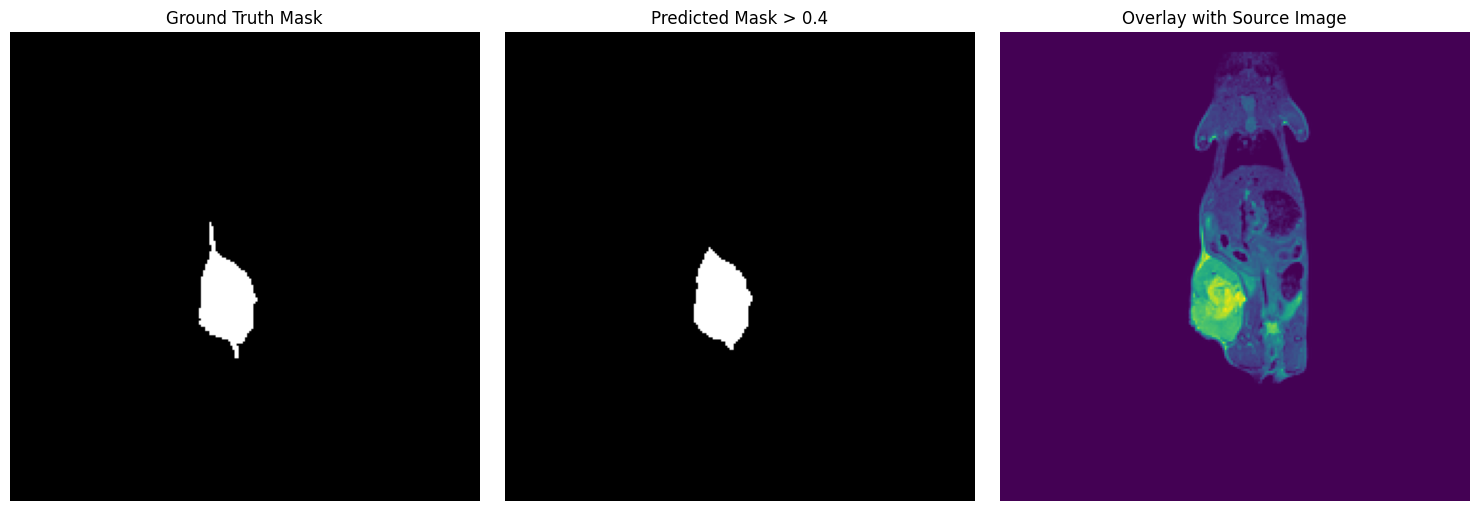

In [209]:
import matplotlib.pyplot as plt

# Assuming 'source_image', 'sample_gt_mask', and 'sample_pred_mask' are numpy arrays
# Display side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original ground truth mask
axes[0].imshow(sample_gt_mask.numpy(), cmap='gray')
axes[0].set_title("Ground Truth Mask")
axes[0].axis('off')

# Prediction mask thresholded
axes[1].imshow(sample_pred_mask > 0.4, cmap='gray')
axes[1].set_title("Predicted Mask > 0.4")
axes[1].axis('off')

# Overlay source image with ground truth and predicted masks
overlay_image = all_images[2][3][0].numpy().copy()
# Adjust overlay to include masks for better visibility
# overlay_image[sample_gt_mask > 0] = [255, 0, 0]  # Example: red for GT
# overlay_image[sample_pred_mask > 0.95] = [0, 255,
#                                           0]  # Example: green for prediction

axes[2].imshow(overlay_image)
axes[2].set_title("Overlay with Source Image")
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [188]:
overlay_image.shape


(224, 224)

In [190]:
sample_gt_mask.shape

torch.Size([224, 224])

In [174]:
overlay_image.shape

(224, 224)

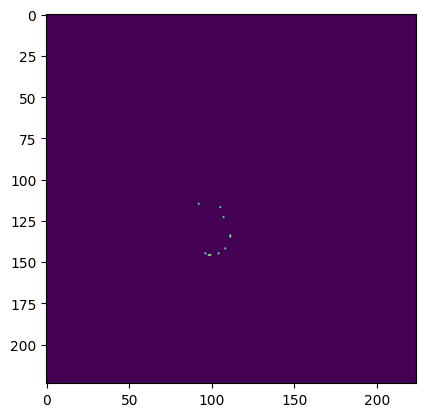

TypeError: imshow() missing 1 required positional argument: 'X'

In [91]:
import matplotlib.pyplot as plt

plt.imshow((gt_msk_batch[1, 0] -
            torch.sigmoid(pred_mask[1, 0]).detach().cpu()) > 0.15)
plt.show()
plt.imshow()
plt.show()


In [10]:
img_batch.shape

torch.Size([8, 3, 224, 224])

In [11]:
model.eval()
for img_batch, gt_msk_batch in val_dataloader:

    pred_mask = model(img_batch.to(device))
    continue

In [12]:
gt_msk_batch.shape

torch.Size([8, 1, 224, 224])

In [18]:
gt_msk_batch.shape

torch.Size([8, 1, 224, 224])

In [30]:
import matplotlib.pyplot as plt

batch_idx = 2
msk = torch.sigmoid(pred_mask)[batch_idx, :1].to('cpu').detach().numpy().T

image = torch.sigmoid(img_batch)[batch_idx, :].to('cpu').detach().numpy().T

true_gt = torch.sigmoid(gt_msk_batch)[batch_idx,
                                      0].to('cpu').detach().numpy().T
tumor = image * msk > 0.95

plt.imshow(tumor)

Error in callback <function _draw_all_if_interactive at 0x2b892a840> (for post_execute), with arguments args (),kwargs {}:


ValueError: arrays must be of dtype byte, short, float32 or float64

ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 640x480 with 1 Axes>

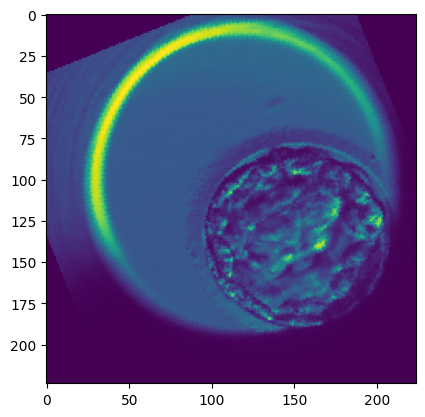

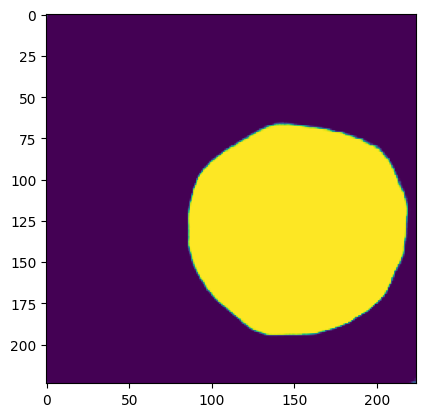

In [16]:
import matplotlib.pyplot as plt

plt.imshow(torch.sigmoid(img_batch)[5, :].to('cpu').detach().numpy().T)
plt.show()
plt.imshow(torch.sigmoid(pred_msk)[5, :].to('cpu').detach().numpy().T)

In [20]:
 validate(model, val_dataloader)

Validating...:  10%|█         | 1/10 [00:08<01:20,  8.95s/it]


RuntimeError: MPS backend out of memory (MPS allocated: 16.87 GB, other allocations: 1.09 GB, max allowed: 18.13 GB). Tried to allocate 196.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).